In [1]:
import os
import cv2
from PIL import Image
from glob import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
image_folder = 'Image Folder'
model_path = 'Model'
frame_path = "Image Folder\\frame0000.jpg"

In [4]:
def convert_video_to_images(img_folder, filename='assignment3_video.avi'):
    """
    Converts the video file (assignment3_video.avi) to JPEG images.
    Once the video has been converted to images, then this function doesn't
    need to be run again.
    Arguments
    ---------
    filename : (string) file name (absolute or relative path) of video file.
    img_folder : (string) folder where the video frames will be
    stored as JPEG images.
    """

    # Make the img_folder if it doesn't exist.'
    try:
        if not os.path.exists(img_folder):
            os.makedirs(img_folder)
    except OSError:
        print('Error')
    # Make sure that the abscense/prescence of path
    # separator doesn't throw an error.
    img_folder = f'{img_folder.rstrip(os.path.sep)}{os.path.sep}'
    # Instantiate the video object.
    video = cv2.VideoCapture(filename)
    # Check if the video is opened successfully
    if not video.isOpened():
        print("Error opening video file")
    
    i = 0
    while video.isOpened():
        ret, frame = video.read()
        if ret:
            im_fname = f'{img_folder}frame{i:0>4}.jpg'
            print('Captured...', im_fname)
            cv2.imwrite(im_fname, frame)
            i += 1
        else:
            break
            
    video.release()
    cv2.destroyAllWindows()
    if i!=0:
        print(f'Video converted\n{i} images written to {img_folder}')
    

In [5]:
def load_images(img_dir, im_width=60, im_height=44):
    """
    Reads, resizes and normalizes the extracted image frames from a folder.
    The images are returned both as a Numpy array of flattened images (i.e. the images with the 3-d shape (im_width, im_height, num_channels) are reshaped into the 1-d shape (im_width x im_height x num_channels)) and a list with the images with their original number of dimensions suitable for display.
    Arguments
    ---------
    img_dir : (string) the directory where the images are stored.
    im_width : (int) The desired width of the image.
    The default value works well.
    im_height : (int) The desired height of the image.
    The default value works well.
    Returns
    X : (numpy.array) An array of the flattened images.
    images : (list) A list of the resized images.
    """
    images = []
    fnames = glob(f'{img_dir}{os.path.sep}frame*.jpg')
    fnames.sort()
    for fname in fnames:
        im = Image.open(fname)
        # resize the image to im_width and im_height.
        im_array = np.array(im.resize((im_width, im_height)))
        # Convert uint8 to decimal and normalize to 0 - 1.
        images.append(im_array.astype(np.float32) / 255.)
        # Close the PIL image once converted and stored.
        im.close()

    # Flatten the images to a single vector
    X = np.array(images).reshape(-1, np.prod(images[0].shape))
    return X, images

In [47]:
def predict(frame):
    """
    Argument
    --------
    frame : Video frame with shape == (44, 60, 3) and dtype == float.
    Return
    anomaly : A boolean indicating whether the frame is an anomaly or not.
    Rough Estimates:
        threashold for max sensitivity = 0.0010316
        threashold for max specificity = 0.0011981
        avg threashold = 0.0011485
    ------
    """
    im_array = np.array(frame.resize((60, 44)))
    im = im_array.astype(np.float32) / 255.
    im = im.reshape((1, -1))
    loaded_model = tf.keras.models.load_model(model_path)
    loss = loaded_model.evaluate(im, im, verbose = 0)
    anomaly = False
    if loss>0.0011485:
        anomaly = True

    # Your fancy computations here!!
    return anomaly

In [ ]:
convert_video_to_images(image_folder, filename='assignment3_video.avi')

In [8]:
flat_img, list_img = load_images(img_dir = image_folder)

In [9]:
X_train = flat_img[0:699]
X_test = flat_img[950:]

In [ ]:
input_img = keras.Input(shape=(len(X_train[0]),))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(len(X_train[0]), activation='sigmoid')(decoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5, epsilon=1e-6))

autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=100,
                shuffle=True,
                validation_data=(X_test, X_test))

In [11]:
autoencoder.save(model_path, overwrite=True)

INFO:tensorflow:Assets written to: Model\assets


In [12]:
loss = []
for i in range (flat_img.shape[0]):
    test = flat_img[i].reshape((1, -1))
    loss.append(autoencoder.evaluate(test, test, verbose = 0))

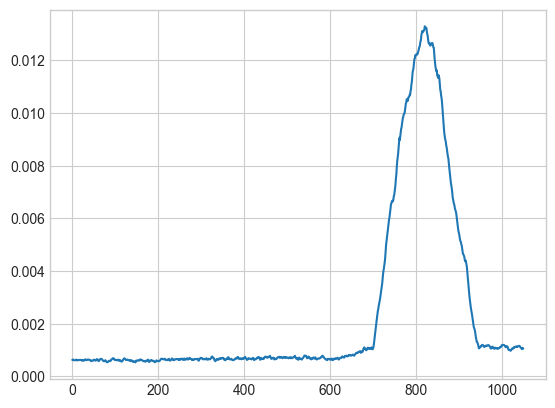

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()
x = list(range(1050))

ax.plot(x, loss)

In [50]:
frame_path = "Image Folder\\frame0900.jpg"
frame = Image.open(frame_path)
predict(frame)

True